## 03 models

In [1]:
# imports and libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import LinearSVC

from scipy.stats import uniform, loguniform

pd.options.display.max_colwidth = 400

In [2]:
# seaborn styling
import seaborn as sns

sns.set_context('notebook') # size of text/graph elements
#sns.despine() # takes away axes on charts with no grid
sns.set_style('white') # background of chart color and if grid is present

### import all_witcher_5000 df and format

In [3]:
# pickle in all_witcher_5000 df
with open('dataframes/all_witcher_5000.pkl', mode= 'rb') as pickle_in: 
    all_witcher_5000= pickle.load(pickle_in)

In [4]:
all_witcher_5000.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9781 entries, 0 to 4994
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   subreddit     9781 non-null   object 
 1   title         9781 non-null   object 
 2   selftext      9781 non-null   object 
 3   score         9781 non-null   int64  
 4   upvote_ratio  9781 non-null   float64
 5   num_comments  9781 non-null   int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 534.9+ KB


In [5]:
# drop index so range is reflective of current total rows, not out of 10000 with removed rows

all_witcher_5000.reset_index(drop= True, inplace= True)

In [6]:
all_witcher_5000.head()

,subreddit,title,selftext,score,upvote_ratio,num_comments
0,Witcher3,Why did CD never patch the Wolf set bug?,This bug has always frustrated me. Why couldn't they ever fix this? The armour is practically unobtainable until NG+. Why didn't they ever patch that bug?,1,1.0,0
1,Witcher3,The heart of the woods quest,"As you may remember/ know, the quest has two choices. I wasn’t really paying attention and picked the way where you kill the 5 wolves and offer it to the woods. And I was just wondering was that the right choice? Everyone except you dies at the end so it’s hard to know",1,1.0,0
2,Witcher3,Bought the complete edition on PS4,I had this in Xbox but ended up moving and left most of my Xbox games behind so I saw the complete edition on sale so I had to snatch this up. I have never beat the game and recently just bought a 40' inch Vizio. . .I feel that this run on the game will be much more beautiful. What is your favorite part of this game? Please no spoilers.,1,1.0,0
3,Witcher3,This merchant will give you 10 crowns minimum for any book! And the higher priced books he will give around 200 up to 350.,,1,1.0,0
4,Witcher3,When will my winter berry’s grow back,Ice tried everything saving and quitting skipping time I’ve been spending hours actually playing the game the plants right next to them are growing back but the winter berry’s won’t,1,1.0,0


### model setup and baseline accuracy

In [7]:
X= all_witcher_5000['title']
y= all_witcher_5000['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [8]:
# baseline accuracy
y.value_counts(normalize= True)

Witcher3          0.507719
netflixwitcher    0.492281
Name: subreddit, dtype: float64

In [10]:
X.shape, X_train.shape, X_test.shape

((9781,), (7335,), (2446,))

### create new custon stop words list for count vectorization

In [9]:
default_stop_words = list(CountVectorizer(stop_words = 'english').get_stop_words())
witcher_stop_words = ['did', 'got', 'just', 'does', 'need', 'amp', 've', 'amp']

custom_stop_words = default_stop_words + witcher_stop_words

### model 1: cv/mnb- randomsearch

In [11]:
pipe_cv_mnb= Pipeline([
    ('cv', CountVectorizer()),
    ('mnb', MultinomialNB())
])

pipe_cv_mnb.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'cv', 'mnb', 'cv__analyzer', 'cv__binary', 'cv__decode_error', 'cv__dtype', 'cv__encoding', 'cv__input', 'cv__lowercase', 'cv__max_df', 'cv__max_features', 'cv__min_df', 'cv__ngram_range', 'cv__preprocessor', 'cv__stop_words', 'cv__strip_accents', 'cv__token_pattern', 'cv__tokenizer', 'cv__vocabulary', 'mnb__alpha', 'mnb__class_prior', 'mnb__fit_prior'])

In [21]:
pipe_cv_mnb_params = {
    'cv__stop_words': ['english', custom_stop_words], 
    'cv__min_df': uniform(0, 0.15),
    'cv__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'cv__max_features': [1_500, 2_000]
}

rs_cv_mnb= RandomizedSearchCV(pipe_cv_mnb, param_distributions= pipe_cv_mnb_params, cv= 5, n_jobs = -2,
                              verbose= 2, random_state= 42, n_iter = 100, error_score='raise', scoring= 'f1_weighted')
rs_cv_mnb.fit(X_train, y_train)

print(f'best score: {rs_cv_mnb.best_score_}')
print(f'best params: {rs_cv_mnb.best_params_}')
print()
print(f'train score: {rs_cv_mnb.score(X_train, y_train)}')
print(f'test score: {rs_cv_mnb.score(X_test, y_test)}')

Fitting 5 folds for each of 100 candidates, totalling 500 fits
best score: 0.8121431486629762
best params: {'cv__max_features': 2000, 'cv__min_df': 0.0008283175685403598, 'cv__ngram_range': (1, 3), 'cv__stop_words': 'english'}

train score: 0.8375451934135564
test params: 0.812114677744125


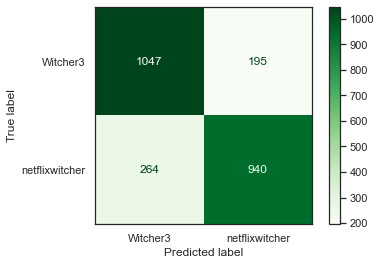

In [20]:
plot_confusion_matrix(rs_cv_mnb, X_test, y_test, cmap= 'Greens');

### model 2: cv/mnb- gridsearch

In [46]:
pipe_cv_mnb= Pipeline([
    ('cv', CountVectorizer()),
    ('mnb', MultinomialNB())
])

pipe_cv_mnb.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'cv', 'mnb', 'cv__analyzer', 'cv__binary', 'cv__decode_error', 'cv__dtype', 'cv__encoding', 'cv__input', 'cv__lowercase', 'cv__max_df', 'cv__max_features', 'cv__min_df', 'cv__ngram_range', 'cv__preprocessor', 'cv__stop_words', 'cv__strip_accents', 'cv__token_pattern', 'cv__tokenizer', 'cv__vocabulary', 'mnb__alpha', 'mnb__class_prior', 'mnb__fit_prior'])

In [47]:
pipe_cv_mnb_params = {
    'cv__stop_words': ['english', custom_stop_words], 
    'cv__min_df': [2, 5, 10],
    'cv__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'cv__max_features': [500, 750]
}

gs_cv_mnb= GridSearchCV(pipe_cv_mnb, param_grid= pipe_cv_mnb_params, cv= 5, verbose= 1) # 5-fold cross-validation.
gs_cv_mnb.fit(X_train, y_train)

print(f'best score: {gs_cv_mnb.best_score_}')
print(f'best params: {gs_cv_mnb.best_params_}')
print()
print(f'train score: {gs_cv_mnb.score(X_train, y_train)}')
print(f'test score: {gs_cv_mnb.score(X_test, y_test)}')

Fitting 5 folds for each of 36 candidates, totalling 180 fits
best score: 0.8031356509884118
best params: {'cv__max_features': 750, 'cv__min_df': 5, 'cv__ngram_range': (1, 1), 'cv__stop_words': ['describe', 'were', 'seem', 'thereafter', 'six', 'much', 'otherwise', 'to', 'each', 'these', 'from', 'whole', 'toward', 'never', 'thence', 'everywhere', 'back', 'becoming', 'being', 'former', 'nevertheless', 'seems', 'hundred', 'herein', 'least', 'ever', 'though', 'therein', 'after', 'was', 'etc', 'why', 'any', 'latterly', 'thereupon', 'his', 'sixty', 'always', 'by', 'interest', 'has', 'or', 'part', 'both', 'upon', 'this', 'via', 'see', 'namely', 'of', 'further', 'meanwhile', 'hasnt', 'detail', 'mostly', 'bill', 'are', 'becomes', 'for', 'another', 'beyond', 'nobody', 'top', 'ie', 'now', 'without', 'nowhere', 'very', 'done', 'you', 'besides', 'themselves', 'whereas', 'however', 'again', 'get', 'there', 'here', 'could', 'behind', 'into', 'my', 'neither', 'eg', 'rather', 'the', 'still', 'whether',

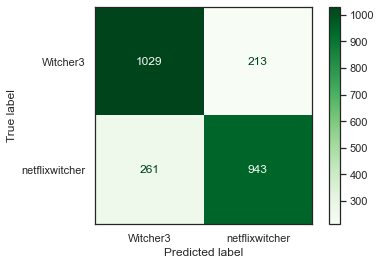

In [48]:
plot_confusion_matrix(gs_cv_mnb, X_test, y_test, cmap= 'Greens');

### model 3: cv/log- gridsearch

In [25]:
pipe_cv_log= Pipeline([
    ('cv', CountVectorizer()),
    ('log', LogisticRegression()),
])

pipe_cv_log.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'cv', 'log', 'cv__analyzer', 'cv__binary', 'cv__decode_error', 'cv__dtype', 'cv__encoding', 'cv__input', 'cv__lowercase', 'cv__max_df', 'cv__max_features', 'cv__min_df', 'cv__ngram_range', 'cv__preprocessor', 'cv__stop_words', 'cv__strip_accents', 'cv__token_pattern', 'cv__tokenizer', 'cv__vocabulary', 'log__C', 'log__class_weight', 'log__dual', 'log__fit_intercept', 'log__intercept_scaling', 'log__l1_ratio', 'log__max_iter', 'log__multi_class', 'log__n_jobs', 'log__penalty', 'log__random_state', 'log__solver', 'log__tol', 'log__verbose', 'log__warm_start'])

In [26]:
pipe_cv_log_params = {
    'cv__stop_words': ['english', custom_stop_words], 
    'cv__min_df': [2, 5, 10],
    'cv__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'cv__max_features': [1_000],
    'log__C': np.logspace(0.001, 10, 10),
    'log__penalty': ['l1', 'l2'],
    'log__solver': ['liblinear'],
    'log__max_iter': [1_000]
}

gs_cv_log= GridSearchCV(pipe_cv_log, param_grid= pipe_cv_log_params, cv= 5, verbose= 1) # 5-fold cross-validation.
gs_cv_log.fit(X_train, y_train)

print(f'best score: {gs_cv_log.best_score_}')
print(f'best params: {gs_cv_log.best_params_}')
print()
print(f'train score: {gs_cv_log.score(X_train, y_train)}')
print(f'test score: {gs_cv_log.score(X_test, y_test)}')

Fitting 5 folds for each of 360 candidates, totalling 1800 fits
best score: 0.8104976141785958
best params: {'cv__max_features': 1000, 'cv__min_df': 5, 'cv__ngram_range': (1, 1), 'cv__stop_words': 'english', 'log__C': 1.0023052380778996, 'log__max_iter': 1000, 'log__penalty': 'l1', 'log__solver': 'liblinear'}

train score: 0.8553510565780504
test params: 0.8152085036794767


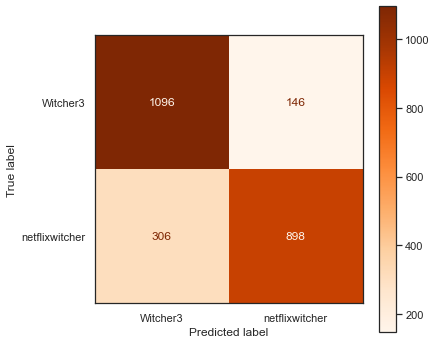

In [93]:
fig, ax = plt.subplots(figsize=(6, 6)) # from https://stackoverflow.com/questions/59839782/confusion-matrix-font-size
plot_confusion_matrix(gs_cv_log, X_test, y_test, cmap= 'Oranges', ax= ax);

In [105]:
tn, fp, fn, tp= 1096, 146, 306, 898

spec = tn / (tn + fp)
print(f'specificity:{round(spec, 3)}')

sens = tp / (tp + fn)
print(f'sensitivity: {round(sens, 3)}')

acc= (tn + tp) / (tp + tn + fp + fn)
print(f'accuracy: {round(acc, 3)}')

specificity:0.882
sensitivity: 0.746
accuracy: 0.815


### model 4: tfidf/log- gridsearch

In [10]:
pipe_tfidf_log= Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('log', LogisticRegression()),
])

pipe_tfidf_log.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'tfidf', 'log', 'tfidf__analyzer', 'tfidf__binary', 'tfidf__decode_error', 'tfidf__dtype', 'tfidf__encoding', 'tfidf__input', 'tfidf__lowercase', 'tfidf__max_df', 'tfidf__max_features', 'tfidf__min_df', 'tfidf__ngram_range', 'tfidf__norm', 'tfidf__preprocessor', 'tfidf__smooth_idf', 'tfidf__stop_words', 'tfidf__strip_accents', 'tfidf__sublinear_tf', 'tfidf__token_pattern', 'tfidf__tokenizer', 'tfidf__use_idf', 'tfidf__vocabulary', 'log__C', 'log__class_weight', 'log__dual', 'log__fit_intercept', 'log__intercept_scaling', 'log__l1_ratio', 'log__max_iter', 'log__multi_class', 'log__n_jobs', 'log__penalty', 'log__random_state', 'log__solver', 'log__tol', 'log__verbose', 'log__warm_start'])

In [11]:
pipe_tfidf_log_params = {
    'tfidf__stop_words': ['english', custom_stop_words], 
    'tfidf__min_df': [2, 5, 10],
    'tfidf__max_df': [0.25, 0.5],
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'tfidf__max_features': [1_000],
    'log__C': np.logspace(0.001, 10, 10),
    'log__penalty': ['l1', 'l2'],
    'log__solver': ['liblinear'],
    'log__max_iter': [1_000]
}

gs_tfidf_log= GridSearchCV(pipe_tfidf_log, param_grid= pipe_tfidf_log_params, cv= 5, verbose= 1) # 5-fold cross-validation.
gs_tfidf_log.fit(X_train, y_train)

print(f'best score: {gs_tfidf_log.best_score_}')
print(f'best params: {gs_tfidf_log.best_params_}')
print()
print(f'train score: {gs_tfidf_log.score(X_train, y_train)}')
print(f'test score: {gs_tfidf_log.score(X_test, y_test)}')

Fitting 5 folds for each of 720 candidates, totalling 3600 fits


C:\Users\kindb\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


best score: 0.812542603953647
best params: {'log__C': 1.0023052380778996, 'log__max_iter': 1000, 'log__penalty': 'l2', 'log__solver': 'liblinear', 'tfidf__max_df': 0.25, 'tfidf__max_features': 1000, 'tfidf__min_df': 5, 'tfidf__ngram_range': (1, 1), 'tfidf__stop_words': ['here', 'any', 'ourselves', 'beyond', 'nine', 'yours', 'first', 'sincere', 'may', 'thence', 'this', 'while', 'throughout', 'twenty', 'how', 'con', 'elsewhere', 'six', 'yourself', 'wherein', 'nor', 'his', 'him', 'hers', 'thereupon', 'though', 'its', 'each', 'never', 'do', 'after', 'two', 'neither', 'when', 'behind', 'namely', 'please', 'with', 'serious', 'take', 'across', 'below', 'seeming', 'once', 'me', 'anyhow', 'over', 'whenever', 'see', 'your', 'nothing', 'too', 'also', 'go', 'there', 'have', 'be', 'whatever', 'during', 'nevertheless', 'five', 'into', 'whereupon', 'top', 'both', 'before', 'that', 'as', 'my', 'you', 'among', 'so', 'an', 'in', 'she', 'nowhere', 'one', 'further', 're', 'via', 'everything', 'and', 'well

<Figure size 576x576 with 0 Axes>

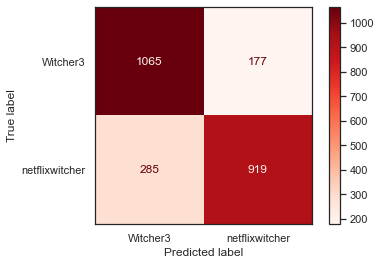

In [12]:
plt.figure(figsize= (8,8))
plot_confusion_matrix(gs_tfidf_log, X_test, y_test, cmap= 'Reds');

### model 5: tfidf/mnb- gridsearch

In [18]:
pipe_tfidf_mnb= Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('mnb', MultinomialNB())
])

pipe_tfidf_mnb.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'tfidf', 'mnb', 'tfidf__analyzer', 'tfidf__binary', 'tfidf__decode_error', 'tfidf__dtype', 'tfidf__encoding', 'tfidf__input', 'tfidf__lowercase', 'tfidf__max_df', 'tfidf__max_features', 'tfidf__min_df', 'tfidf__ngram_range', 'tfidf__norm', 'tfidf__preprocessor', 'tfidf__smooth_idf', 'tfidf__stop_words', 'tfidf__strip_accents', 'tfidf__sublinear_tf', 'tfidf__token_pattern', 'tfidf__tokenizer', 'tfidf__use_idf', 'tfidf__vocabulary', 'mnb__alpha', 'mnb__class_prior', 'mnb__fit_prior'])

In [51]:
pipe_tfidf_mnb_params = {
    'tfidf__stop_words': ['english', custom_stop_words], 
    'tfidf__min_df': [1, 2, 3],
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'tfidf__max_features': [500, 720, 1_000],
    'mnb__alpha': [1]
}

gs_tfidf_mnb= GridSearchCV(pipe_tfidf_mnb, param_grid= pipe_tfidf_mnb_params, cv= 5, verbose= 1) # 5-fold cross-validation.
gs_tfidf_mnb.fit(X_train, y_train)

print(f'best score: {gs_tfidf_mnb.best_score_}')
print(f'best params: {gs_tfidf_mnb.best_params_}')
print()
print(f'train score: {gs_tfidf_mnb.score(X_train, y_train)}')
print(f'test score: {gs_tfidf_mnb.score(X_test, y_test)}')

Fitting 5 folds for each of 54 candidates, totalling 270 fits
best score: 0.8096796182685754
best params: {'mnb__alpha': 1, 'tfidf__max_features': 1000, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 1), 'tfidf__stop_words': ['hereby', 'part', 'something', 'therein', 'whence', 'interest', 'before', 'none', 'rather', 'here', 'eleven', 'seemed', 'twenty', 'whither', 'on', 'them', 'amoungst', 'nine', 'be', 'hundred', 'except', 'down', 'yet', 'upon', 'herein', 'hers', 'herself', 'moreover', 'and', 'seem', 'can', 'another', 'least', 'co', 'still', 'my', 'toward', 'cry', 'such', 'hereafter', 'keep', 'everything', 'name', 'few', 'most', 'also', 'us', 'cant', 'whatever', 'myself', 'nowhere', 'it', 'who', 'by', 'thus', 'four', 'this', 'through', 'everyone', 'although', 'move', 'thick', 'so', 'serious', 'whereby', 'among', 'get', 'throughout', 'is', 'last', 'yourselves', 'these', 'inc', 'whereafter', 'very', 'find', 'indeed', 'next', 'must', 'above', 'forty', 'often', 'mostly', 'perhaps', 'himsel

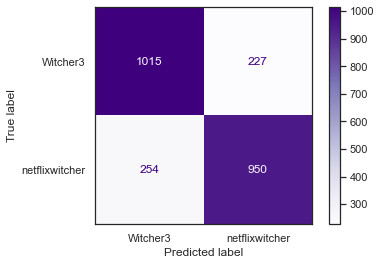

In [49]:
plot_confusion_matrix(gs_mnb_log, X_test, y_test, cmap= 'Purples');

### model 6: tfidf/mnb- randomsearch

In [44]:
pipe_tfidf_mnb= Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('mnb', MultinomialNB())
])

pipe_tfidf_mnb.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'tfidf', 'mnb', 'tfidf__analyzer', 'tfidf__binary', 'tfidf__decode_error', 'tfidf__dtype', 'tfidf__encoding', 'tfidf__input', 'tfidf__lowercase', 'tfidf__max_df', 'tfidf__max_features', 'tfidf__min_df', 'tfidf__ngram_range', 'tfidf__norm', 'tfidf__preprocessor', 'tfidf__smooth_idf', 'tfidf__stop_words', 'tfidf__strip_accents', 'tfidf__sublinear_tf', 'tfidf__token_pattern', 'tfidf__tokenizer', 'tfidf__use_idf', 'tfidf__vocabulary', 'mnb__alpha', 'mnb__class_prior', 'mnb__fit_prior'])

In [45]:
pipe_tfidf_mnb_params = {
    'tfidf__stop_words': ['english', custom_stop_words], 
    'tfidf__min_df': uniform(0, 0.15),
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'tfidf__max_features': [500, 720, 1_000],
    'mnb__alpha': [1]
}

rs_tfidf_mnb= RandomizedSearchCV(pipe_tfidf_mnb, param_distributions= pipe_tfidf_mnb_params, cv= 5, n_jobs = -2,
                              verbose= 2, random_state= 42, n_iter = 100, error_score='raise', scoring= 'f1_weighted')
rs_tfidf_mnb.fit(X_train, y_train)

print(f'best score: {rs_tfidf_mnb.best_score_}')
print(f'best params: {rs_tfidf_mnb.best_params_}')
print()
print(f'train score: {rs_tfidf_mnb.score(X_train, y_train)}')
print(f'test score: {rs_tfidf_mnb.score(X_test, y_test)}')

Fitting 5 folds for each of 100 candidates, totalling 500 fits
best score: 0.7914523536728317
best params: {'mnb__alpha': 1, 'tfidf__max_features': 1000, 'tfidf__min_df': 0.001989744173979979, 'tfidf__ngram_range': (1, 1), 'tfidf__stop_words': ['hereby', 'part', 'something', 'therein', 'whence', 'interest', 'before', 'none', 'rather', 'here', 'eleven', 'seemed', 'twenty', 'whither', 'on', 'them', 'amoungst', 'nine', 'be', 'hundred', 'except', 'down', 'yet', 'upon', 'herein', 'hers', 'herself', 'moreover', 'and', 'seem', 'can', 'another', 'least', 'co', 'still', 'my', 'toward', 'cry', 'such', 'hereafter', 'keep', 'everything', 'name', 'few', 'most', 'also', 'us', 'cant', 'whatever', 'myself', 'nowhere', 'it', 'who', 'by', 'thus', 'four', 'this', 'through', 'everyone', 'although', 'move', 'thick', 'so', 'serious', 'whereby', 'among', 'get', 'throughout', 'is', 'last', 'yourselves', 'these', 'inc', 'whereafter', 'very', 'find', 'indeed', 'next', 'must', 'above', 'forty', 'often', 'mostly'

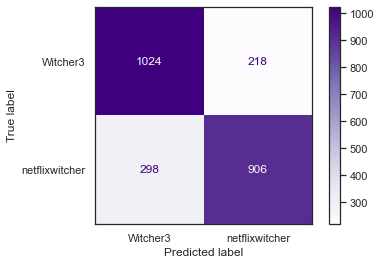

In [47]:
plot_confusion_matrix(rs_tfidf_mnb, X_test, y_test, cmap= 'Purples');

### misclassification analysis

In [ ]:
# went to with the cv/log model cause it had the highest train score and test score

In [46]:
test_preds= gs_cv_log.predict(X_test)

misclass= X_test.copy().to_frame()

In [51]:
# add true class and predicted class columns to misclass df
misclass['true_class']= y_test.values
misclass['predicted_class']= test_preds

misclass_df= misclass[misclass['true_class'] != misclass['predicted_class']]

misclass_df.shape # how many posts were misclassified

In [56]:
df= misclass_df.merge(all_witcher_5000, left_index=True, right_index=True).drop(columns= ['selftext', 'subreddit', 'title_x'])

df[100:150] # for looking at subset of missclassed data

In [109]:
# look at misclassified posts based on specific words

words= ['dandelion', 'jaskier', 'cosplay', 'gwent', 'yennefer']

misclass_words= pd.DataFrame()

for word in words:
    mc_words= misclass_df[misclass_df['title'].str.lower().str.contains(word)]
    misclass_words= misclass_words.append(mc_words, ignore_index= True)

misclass_words

,title,true_class,predicted_class
0,Dandelion cosplay by GraysonFin,netflixwitcher,Witcher3
1,A very easy way to show how what Jaskiers song has done to me when I first heard it,netflixwitcher,Witcher3
2,"Our first witcher ""cosplay"" for halloween🙃",netflixwitcher,Witcher3
3,Yennefer of Vengerberg cosplay,Witcher3,netflixwitcher
4,Ciri cosplay by cherrycrush,Witcher3,netflixwitcher
5,Dandelion cosplay by GraysonFin,netflixwitcher,Witcher3
6,More Geralt Cosplay!,netflixwitcher,Witcher3
7,Look I caught a wild beast! ( Geralt cosplay.... featuring my cat. Who wanted to know what I was doing.) ( self.),netflixwitcher,Witcher3
8,Cosplay Witcher3 mesh with Netflix Geralt. 2 months of work for Halloween.,Witcher3,netflixwitcher
9,Queen Calanthe of Cintra cosplay by Felora (books),Witcher3,netflixwitcher
